# Cat vs Dog with Transfer Learning

This project owned by `Gatum Erlangga`, aims to solve cat vs dog problem using transfer learning. Inception V3 is a model used in this project. Pre-trained model is from https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5.

This project is a modification and exploration of Convolutional Neural Network with Tensorflow Course from Deeplearning.AI. This is a future self exploration to deeper my knowledge about deep learning algorithm, especially Convolutional Neural Network.

In [79]:
# Library
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Preprocessing

**Dataset** <br>
`Cat vs Dog` dataset contains training and validation set of cat and dog

In [4]:
# Import Dataset
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-02-28 12:41:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.80.224.107, 2a02:26f0:e3:39c::e59, 2a02:26f0:e3:3af::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.80.224.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   219MB/s    in 3.6s    

2022-02-28 12:42:00 (220 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [6]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


**Prepare training and validation directory** for `flow_from_directory` method of `ImageDataGenerator`

In [40]:
doc_dir = '/tmp/cats-v-dogs'

if os.path.exists(doc_dir):
  shutil.rmtree(doc_dir)

def create_directories(doc_path):
  os.makedirs(os.path.join(doc_path,'training/cats'))
  os.makedirs(os.path.join(doc_path,'training/dogs'))
  os.makedirs(os.path.join(doc_path,'testing/cats'))
  os.makedirs(os.path.join(doc_path,'testing/dogs'))

try:
  create_directories(doc_path=doc_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [31]:
for rootdir, dirs, files in os.walk(doc_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

tmp/cats-v-dogs/training
tmp/cats-v-dogs/testing
tmp/cats-v-dogs/training/dogs
tmp/cats-v-dogs/training/cats
tmp/cats-v-dogs/testing/dogs
tmp/cats-v-dogs/testing/cats


In [42]:
# os.listdir('/tmp/PetImages/Cat/')
# os.listdir(os.path.join('tmp/cats-v-dogs/training/', "cats/"))

**Split Data** into `n%` of training data and `1-n%` validation data

In [22]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  
  source_data = os.listdir(SOURCE_DIR)
  clean_data = []

  # IGNORING CORRUPT/BROKEN IMAGE
  for picture in source_data:
    if (os.path.getsize(os.path.join(SOURCE_DIR, picture)) <= 0):
      print(f'{picture} is zero length, so ignoring.')
      continue
    clean_data.append(picture)

  # SPLIT DATA
  shuffled = random.sample(clean_data, len(clean_data))
  split_index = int(SPLIT_SIZE * len(shuffled));
  training_data = shuffled[:split_index]
  testing_data = shuffled[split_index:]

  # MOVE INTO TRAINING DIRECTORY
  for fname in training_data:
    src = os.path.join(SOURCE_DIR, fname)
    dst = os.path.join(TRAINING_DIR, fname)
    shutil.copyfile(src, dst)
    
  # MOVE INTO VALIDATION DIRECTORY
  for fname in testing_data:
    src = os.path.join(SOURCE_DIR, fname)
    dst = os.path.join(VALIDATION_DIR, fname)
    shutil.copyfile(src, dst)

In [43]:
# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories (for multiple run cell)
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# RUN CUSTOM split_data FUNCTION
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing



Cat Image:


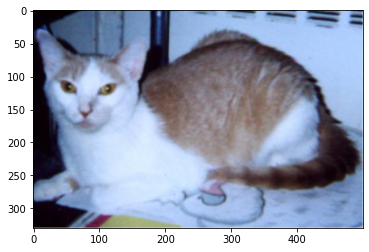

Shape: (330, 500, 3)

Dog Image:


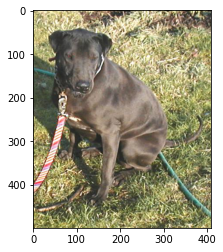

Shape: (500, 408, 3)


In [49]:
print("\nCat Image:")
cat_img = load_img(f"{os.path.join(TRAINING_CATS_DIR, os.listdir(TRAINING_CATS_DIR)[0])}")
plt.imshow(cat_img)
plt.show()
print(f"Shape: {img_to_array(cat_img).shape}")

print("\nDog Image:")
dog_img = load_img(f"{os.path.join(TRAINING_DOGS_DIR, os.listdir(TRAINING_DOGS_DIR)[0])}")
plt.imshow(dog_img)
plt.show()
print(f"Shape: {img_to_array(dog_img).shape}")

**Training and Validation Generators**<br>
I use `keras` `ImageDataGenetor` to handle my training data. It has useful features, such as rescaling, image augmentation and automaticaly load the dataset from directory uses `flow_from_directory` method.

Note
> *steps per epoch = total image / batch size*

In [51]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Initiate ImageDataGenerator object for train data
  train_datagen = ImageDataGenerator(rescale=1./255,            # rescaling image
                                     rotation_range=40,         # rotation 40 degree
                                     horizontal_flip=True,      # enable horizontal flip
                                     shear_range=0.2,           # shear range up to 0.2
                                     zoom_range=0.2,            # zoom image up to 20%
                                     width_shift_range=0.2,     # width shift up to 0.2
                                     height_shift_range=0.2)    # height shift up to 0.2

  # Pass data into flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=30, 
                                                      class_mode='binary',      # only cat vs dog
                                                      target_size=(150, 150))   # input image will be 
                                                                                # 150x150

  # Initiate ImageDataGenerator object for validation data
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass data into flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [53]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Transfer learning - Model Preparation

Model: `Inception V3`

In [54]:
# Download the inception v3 weights (pre trained model)
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-02-28 13:54:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  62.1MB/s    in 1.4s    

2022-02-28 13:54:16 (62.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [59]:
# Import model from keras
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Weight file
weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Create pre trained model based on the previous downloaded weight

In [65]:
def create_pre_trained_model(local_weights_file):

  # Defining model parameter
  # Input shape: shape of the image that will be fed into network
  # Include Top: False -> not including fully connected layer 
  # Weights: set none to random initialization weights
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  # load pre trained weights
  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model
  

**Model Summary**

In [66]:
pre_trained_model = create_pre_trained_model(weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                       

Check the trainable layer

In [67]:
# Trainable
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


## Callbacks
Model will stop its training process once hit 95% accuracy

In [69]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

## Combining pre-trained model with custom model
In this project, I randomly select `mixed8` as the last layer before it connected to my custom model. There's should be future investigation to determine the best layer as the last layer.

In [70]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed8')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output


**Last layer summary**

In [71]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 3, 3, 1280)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 1280), dtype=tf.float32, name=None), name='mixed8/concat:0', description="created by layer 'mixed8'")


**Adding more layer** using `keras` [`Functional API`](https://www.tensorflow.org/guide/keras/functional)

In [73]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


**Create final model**

In [78]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.2)(x)

  # Final layer for binary classification 
  x = layers.Dense(1, activation='sigmoid')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model


In [75]:
# Call model generation method
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 22,997,665 total parameters in this model.
There are 12,322,817 trainable parameters in this model.


In [76]:
# Model training
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

750/750 - 238s - loss: 0.2031 - accuracy: 0.9158 - val_loss: 0.0772 - val_accuracy: 0.9692 - 238s/epoch - 318ms/step
Epoch 2/100
750/750 - 220s - loss: 0.1550 - accuracy: 0.9383 - val_loss: 0.1243 - val_accuracy: 0.9560 - 220s/epoch - 294ms/step
Epoch 3/100
750/750 - 219s - loss: 0.1469 - accuracy: 0.9433 - val_loss: 0.1089 - val_accuracy: 0.9708 - 219s/epoch - 292ms/step
Epoch 4/100
750/750 - 218s - loss: 0.1443 - accuracy: 0.9458 - val_loss: 0.1132 - val_accuracy: 0.9616 - 218s/epoch - 291ms/step
Epoch 5/100
750/750 - 217s - loss: 0.1380 - accuracy: 0.9484 - val_loss: 0.0765 - val_accuracy: 0.9740 - 217s/epoch - 290ms/step
Epoch 6/100
750/750 - 218s - loss: 0.1387 - accuracy: 0.9481 - val_loss: 0.0833 - val_accuracy: 0.9756 - 218s/epoch - 290ms/step
Epoch 7/100

Reached 95.0% accuracy so cancelling training!
750/750 - 216s - loss: 0.1313 - accuracy: 0.9506 - val_loss: 0.0947 - val_accuracy: 0.9684 - 216s/epoch - 287ms/step


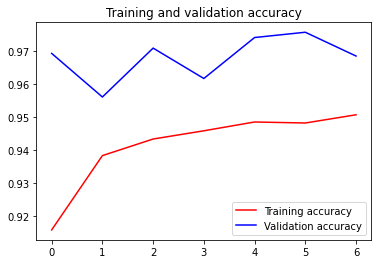

<Figure size 432x288 with 0 Axes>

In [77]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# CONCLUSION

Model reaches training accuracy at 95.06% and validation accuracy at 96.84% in only 7 epochs